In [34]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.dirname(os.path.abspath(os.getcwd()))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from src.data_processing.resultMetaUtils import frameFromResultMeta, deleteRunsFromResults
from src.loaders.dataLoader import CustomDataLoader
from src.core.constants import AUTO, ORDERFLOWS, ORDERBOOKS

In [13]:
# Create the datatframe from the results meta
df = frameFromResultMeta()
print(sorted(df.columns))
cols = [
    'run_id',
    'meta.ticker', 'meta.numEpoch', 'meta.lookForwardHorizon', 'meta.rowLim', 'meta.representation', 'meta.model',
    'metrics.accuracy', 'metrics.confusion_matrix', 'metrics.f1', 'metrics.precision', 'metrics.recall',
]
df = df[cols]
display(df)

['accuracy', 'datetime', 'meta.batchSize', 'meta.lookForwardHorizon', 'meta.maxFiles', 'meta.model', 'meta.modelKwargs.shape', 'meta.numEpoch', 'meta.representation', 'meta.rowLim', 'meta.scaling', 'meta.startDate', 'meta.steps', 'meta.threshold', 'meta.ticker', 'meta.trainDays', 'meta.trainTestSplit', 'metrics.accuracy', 'metrics.confusion_matrix', 'metrics.f1', 'metrics.precision', 'metrics.recall', 'run_id']


,run_id,meta.ticker,meta.numEpoch,meta.lookForwardHorizon,meta.rowLim,meta.representation,meta.model,metrics.accuracy,metrics.confusion_matrix,metrics.f1,metrics.precision,metrics.recall
0,0y7OaOkl,AMZN,5,50,1000000,orderbooks,deepLOB_TF,NaN,NaN,NaN,NaN,NaN
1,15Aoi21E,NVDA,3,500,1000000,orderbooks,deepLOB_TF,0.70226,"[[0, 15273, 0], [0, 70226, 0], [0, 14501, 0]]",0.275030,0.234087,0.333333
2,1MsXo8jI,AAPL,5,20,1000000,orderbooks,deepLOB_TF,NaN,NaN,NaN,NaN,NaN
3,2GPfMf8y,AMZN,1,20,1000000,NaN,deepLOB_PT,NaN,NaN,NaN,NaN,NaN
4,2YFmwhN9,AMZN,5,20,1000000,orderflows,deepLOB_TF,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
146,yWbj9dNx,AMZN,5,10,1000000,orderbooks,deepLOB_TF,NaN,NaN,NaN,NaN,NaN
147,ZqKPhyvX,NVDA,1,10,1000000,orderbooks,deepLOB_TF,NaN,NaN,NaN,NaN,NaN
148,ZSy4YAJl,NFLX,5,200,1000000,orderbooks,deepLOB_TF,NaN,NaN,NaN,NaN,NaN
149,zTwpTd8t,MSFT,5,200,1000000,orderbooks,deepLOB_TF,NaN,NaN,NaN,NaN,NaN


In [14]:
# Temp for deleting some data
tmp = df.loc[df['metrics.accuracy'] < 0.3]
runIDs = tmp['run_id'].values
runIDs
# deleteRunsFromResults(runIDs=runIDs, dryRun=False)

array([], dtype=object)

In [58]:
cdl = CustomDataLoader(
        ticker='NFLX',
        scaling=True,
        horizon=100,
        threshold=AUTO,
        maxFiles=1,
        rowLim=100_000,
        trainTestSplit=0.99,
        lookForwardHorizon=20,
        representation=ORDERFLOWS
)
cdl.runFullProcessReturnXY(tensor=True)
print(cdl.x.shape)
print(cdl.y.shape)
x_test, y_test = cdl.getTestData()
y_test.sum(dim=0)

Extracting data from files...


100%|██████████| 1/1 [00:00<00:00, 26.23it/s]


Auto threshold z-score cutoffs: lower=-0.269, upper=0.272, using threshold=0.271
Extracting data from files...


100%|██████████| 1/1 [00:00<00:00, 46.28it/s]

Train set size: 76925, Test set size: 778
torch.Size([76925, 100, 20, 1])
torch.Size([76925, 3])


tensor([259., 366., 134.])

In [59]:
orderbook = df

orderbook.dropna(subset=['metrics.accuracy'], inplace=True)
orderbook = orderbook[orderbook['meta.lookForwardHorizon'] < 2000]
# print(orderbook)

# Conditions for orderbooks training
conditions = {
    'meta.rowLim': 1000000,
    'meta.representation': 'orderbooks',
    # 'meta.numEpoch': 5,
    'meta.model': 'deepLOB_TF'
}

for condition, value in conditions.items():
    orderbook = orderbook[orderbook[condition] == value]

tickers = orderbook['meta.ticker'].unique()

orderbooks = []
for ticker in tickers:
    orderbooks.append(
        orderbook.loc[orderbook['meta.ticker'] == ticker].sort_values('meta.lookForwardHorizon')
    )
# orderbooks

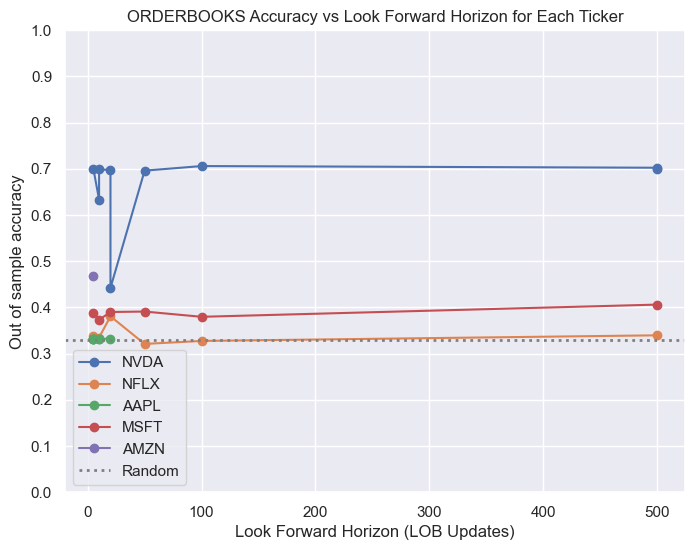

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set()
for d in orderbooks:
    d_sorted = d.sort_values('meta.lookForwardHorizon')
    ax.plot(
        d_sorted['meta.lookForwardHorizon'],
        d_sorted['metrics.accuracy'],
        marker='o',
        label=d_sorted['meta.ticker'].iloc[0]
    )
ax.set_xlabel('Look Forward Horizon (LOB Updates)')
ax.set_ylabel('Out of sample accuracy')
ax.set_ylim(0,1)
ax.set_title('ORDERBOOKS Accuracy vs Look Forward Horizon for Each Ticker')
ax.set_yticks([round(y, 1) for y in list(np.arange(0.0, 1.01, 0.1))])
ax.axhline(0.33, color='gray', linestyle=':', linewidth=2, label='Random')
ax.legend()
plt.show()

In [61]:
orderflow = df

# Conditions for orderbooks training
conditions = {
    'meta.rowLim': 1000000,
    # 'meta.numEpoch': 5,
    'meta.representation': 'orderflows',
}

for condition, value in conditions.items():
    orderflow = orderflow[orderflow[condition] == value]

tickers = orderflow['meta.ticker'].unique()

orderflows = []
for ticker in tickers:
    orderflows.append(
        orderflow.loc[orderflow['meta.ticker'] == ticker].sort_values('meta.lookForwardHorizon')
    )
    
# display(orderflow)

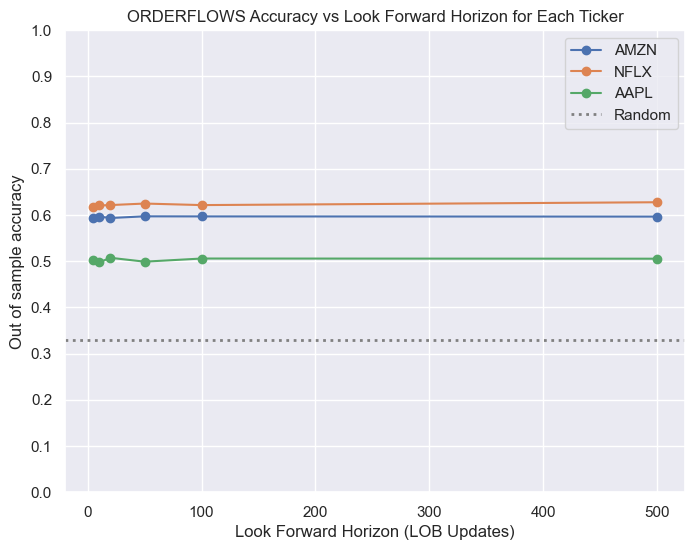

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set()
for d in orderflows:
    ax.plot(
        d['meta.lookForwardHorizon'],
        d['metrics.accuracy'],
        marker='o',
        label=d['meta.ticker'].iloc[0]
    )
ax.set_xlabel('Look Forward Horizon (LOB Updates)')
ax.set_ylabel('Out of sample accuracy')
ax.set_ylim(0,1)
ax.set_title('ORDERFLOWS Accuracy vs Look Forward Horizon for Each Ticker')
ax.set_yticks([round(y, 1) for y in list(np.arange(0.0, 1.01, 0.1))])
ax.axhline(0.33, color='gray', linestyle=':', linewidth=2, label='Random')
ax.legend()
plt.show()

In [66]:
tickers_orderbooks = set(orderbook['meta.ticker'].unique())
tickers_orderflows = set(orderflow['meta.ticker'].unique())
inner_tickers = tickers_orderbooks.intersection(tickers_orderflows)

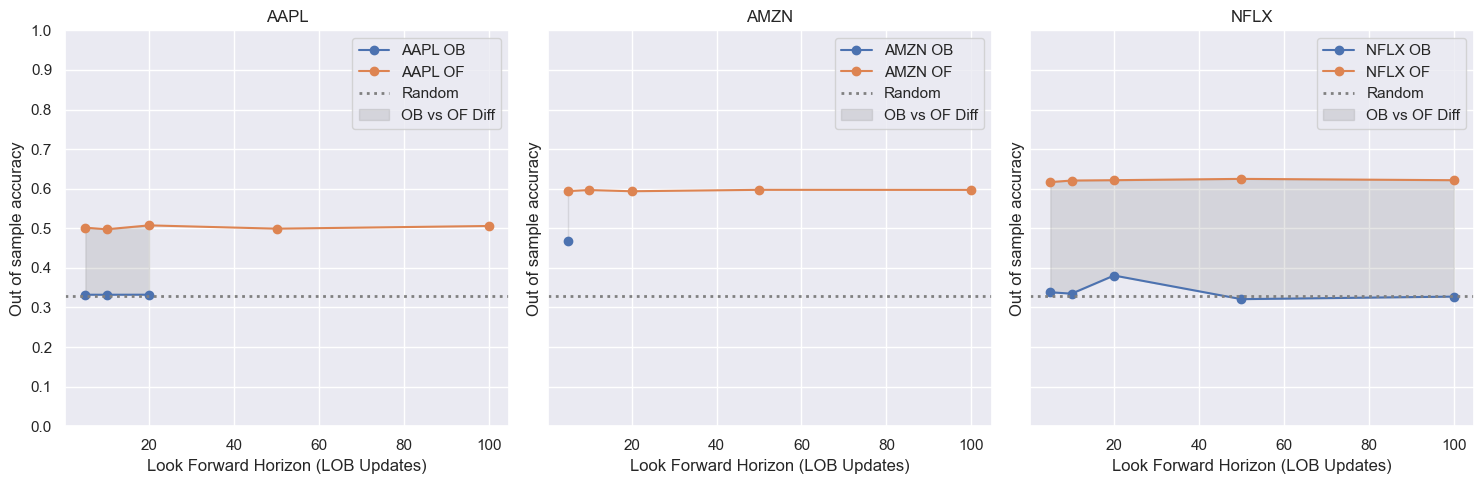

In [70]:
fig, axs = plt.subplots(1, len(inner_tickers), figsize=(15, 5), sharey=True)
if len(inner_tickers) == 1:
    axs = [axs]

for id, ticker in enumerate(sorted(inner_tickers)):
    # For each horizon, pick the first (or best) result for OB and OF
    ob = (
        orderbook[
            (orderbook['meta.ticker'] == ticker) &
            (orderbook['meta.representation'] == 'orderbooks') &
            (orderbook['meta.lookForwardHorizon'] <= 200)
        ]
        .sort_values(['meta.lookForwardHorizon', 'metrics.accuracy'], ascending=[True, False])
        .drop_duplicates(subset=['meta.lookForwardHorizon'], keep='first')
    )
    of = (
        orderflow[
            (orderflow['meta.ticker'] == ticker) &
            (orderflow['meta.representation'] == 'orderflows') &
            (orderflow['meta.lookForwardHorizon'] <= 200)
        ]
        .sort_values(['meta.lookForwardHorizon', 'metrics.accuracy'], ascending=[True, False])
        .drop_duplicates(subset=['meta.lookForwardHorizon'], keep='first')
    )
    ax = axs[id]
    ax.plot(
        ob['meta.lookForwardHorizon'],
        ob['metrics.accuracy'],
        marker='o',
        label=f"{ob['meta.ticker'].iloc[0]} OB"
    )
    ax.plot(
        of['meta.lookForwardHorizon'],
        of['metrics.accuracy'],
        marker='o',
        label=f"{of['meta.ticker'].iloc[0]} OF"
    )
    ax.axhline(0.33, color='gray', linestyle=':', linewidth=2, label='Random')
    ax.set_title(ticker)
    ax.set_xlabel('Look Forward Horizon (LOB Updates)')
    ax.set_ylabel('Out of sample accuracy')  # Set y-axis label for all
    ax.set_ylim(0, 1)
    ax.set_yticks([round(y, 1) for y in np.arange(0.0, 1.01, 0.1)])
    # Align OB and OF on lookForwardHorizon for fill_between
    merged = pd.merge(
        ob[['meta.lookForwardHorizon', 'metrics.accuracy']],
        of[['meta.lookForwardHorizon', 'metrics.accuracy']],
        on='meta.lookForwardHorizon',
        suffixes=('_ob', '_of')
    )
    ax.fill_between(
        merged['meta.lookForwardHorizon'],
        merged['metrics.accuracy_ob'],
        merged['metrics.accuracy_of'],
        color='gray',
        alpha=0.2,
        label='OB vs OF Diff'
    )
    ax.legend()
plt.tight_layout()
plt.show()


[Text(0, 0.5, 'Down (↓)'), Text(0, 1.5, 'Neutral (=)'), Text(0, 2.5, 'Up (↑)')]

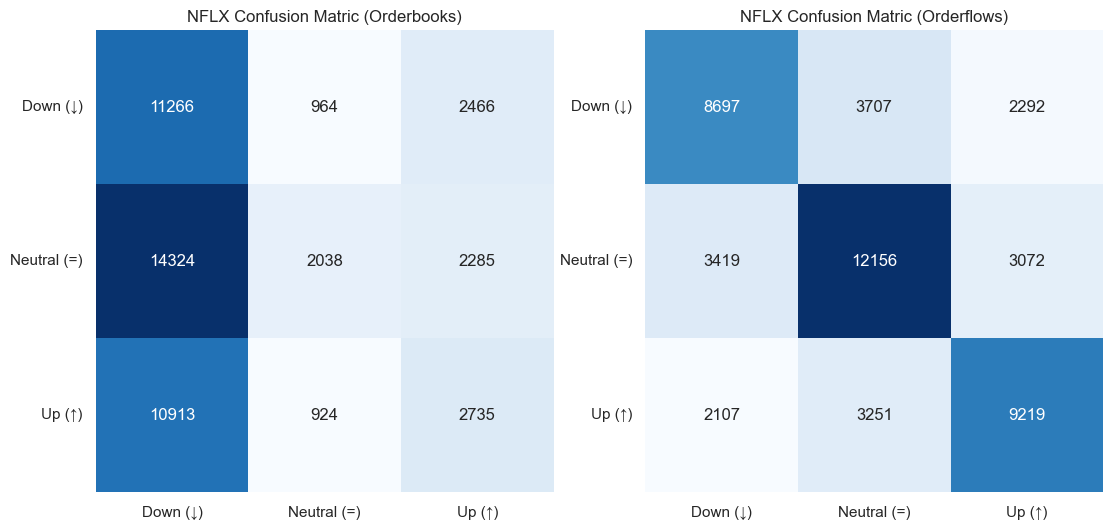

In [137]:
labels = ['Down (↓)', 'Neutral (=)',  'Up (↑)']
ticker = 'NFLX'

fig, ax = plt.subplots(1 , 2, figsize=(13, 6))


nflx_books = df.loc[(df['meta.ticker'] == ticker) & (df['meta.representation'] == 'orderbooks')]
nflx_books = nflx_books.sort_values(by='metrics.precision', ascending=False)
nflx_books.reset_index()
best_nflx_conf_books = nflx_books.iloc[0]['metrics.confusion_matrix']
sns.heatmap(best_nflx_conf_books, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax[0], cbar=False)
ax[0].set_title(f"{ticker} Confusion Matric (Orderbooks)")
ax[0].set_yticklabels(labels, rotation=0)

nflx_flows = df.loc[(df['meta.ticker'] == ticker) & (df['meta.representation'] == 'orderflows')]
nflx_flows = nflx_flows.sort_values(by='metrics.precision', ascending=False)
nflx_flows.reset_index()
best_nflx_conf_flows = nflx_flows.iloc[0]['metrics.confusion_matrix']
sns.heatmap(best_nflx_conf_flows, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax[1], cbar=False)
ax[1].set_title(f"{ticker} Confusion Matric (Orderflows)")
ax[1].set_yticklabels(labels, rotation=0)

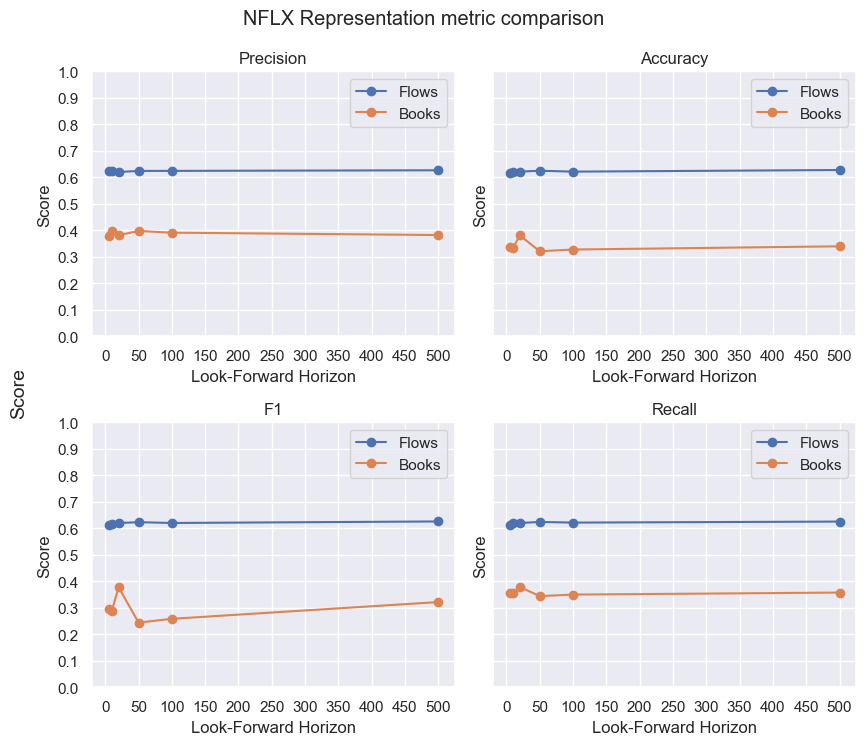

In [174]:
sorted_flows = nflx_flows.sort_values('meta.lookForwardHorizon')
sorted_books = nflx_books.sort_values('meta.lookForwardHorizon')

metrics = ['precision', 'accuracy', 'f1', 'recall']

fig, axs = plt.subplots(2, 2, figsize=(9, 8), sharey=True)  # no sharex
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    ax.plot(
        sorted_flows['meta.lookForwardHorizon'],
        sorted_flows[f'metrics.{metric}'],
        marker='o',
        label='Flows'
    )
    ax.plot(
        sorted_books['meta.lookForwardHorizon'],
        sorted_books[f'metrics.{metric}'],
        marker='o',
        label='Books'
    )
    ax.set_title(metric.capitalize())
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.legend()
    ax.set_xlabel('Look-Forward Horizon')
    ax.set_ylabel('Score')
    ax.set_xticks(np.linspace(0, 500, 11))   # set xticks on each plot
    ax.set_yticks(np.linspace(0, 1, 11))

fig.text(0.04, 0.5, 'Score', va='center', rotation='vertical', fontsize=14)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
fig.suptitle(f"{ticker} Representation metric comparison")
plt.show()
